### Import Libraries

In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

### Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# We can view all of the classes that automap found
# ...and we can also get a listing of all of the columns and their types.
# Fun fact: 'tobs' means 'temperature at time of observation'.
tables = Base.classes.keys()
inspector = inspect(engine)
print(f"--------------------------")
for table in tables:
    print(f"Class: {table.upper()}")
    columns = inspector.get_columns(table)
    for column in columns:
        print(f"{table}.{column['name']}, {column['type']}")
    print(f"--------------------------")

--------------------------
Class: MEASUREMENT
measurement.id, INTEGER
measurement.station, TEXT
measurement.date, TEXT
measurement.prcp, FLOAT
measurement.tobs, FLOAT
--------------------------
Class: STATION
station.id, INTEGER
station.station, TEXT
station.name, TEXT
station.latitude, FLOAT
station.longitude, FLOAT
station.elevation, FLOAT
--------------------------


In [7]:
# Save references to each table
measurementClass = Base.classes.measurement
stationClass = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

### Exploratory Climate Analysis

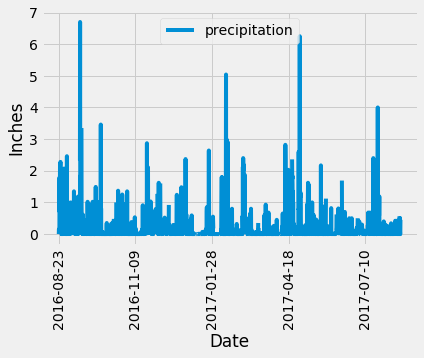

In [9]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
endDate = dt.datetime.strptime(session.query(measurementClass.date).order_by(measurementClass.date.desc()).first()[0], '%Y-%m-%d')
queryDate = dt.datetime.strftime((endDate - dt.timedelta(365)), '%Y-%m-%d')

# Perform a query to retrieve the data and precipitation scores
results = session.query(measurementClass.date, measurementClass.prcp).\
    filter(measurementClass.date >= queryDate).\
    order_by(measurementClass.date)
# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(results, columns=['date', 'precipitation'])
prcp_df.set_index('date', inplace=True)

# Sort the dataframe by date
prcp_df = prcp_df.sort_values(by = ['date'])

# Use Pandas Plotting with Matplotlib to plot the data
prcp_df.plot()
plt.xlabel("Date")
plt.xticks(rotation=90)
plt.ylabel("Inches")
plt.legend(loc="best")
plt.show()

In [10]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [11]:
# Design a query to show how many stations are available in this dataset?
results = session.query(func.count(func.distinct(measurementClass.station))).all()
results

[(9)]

In [12]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
results = session.query(measurementClass.station, func.count(measurementClass.station)).group_by(measurementClass.station).order_by(func.count(measurementClass.station).desc()).all()
# I just want to pretty this up a little:
stations_df = pd.DataFrame(results, columns=['station', 'measurements'])
stations_df.set_index('station', inplace=True)
stations_df

,measurements
station,
USC00519281,2772
USC00519397,2724
USC00513117,2709
USC00519523,2669
USC00516128,2612
USC00514830,2202
USC00511918,1979
USC00517948,1372
USC00518838,511


In [13]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
results = session.query(func.min(measurementClass.tobs), func.max(measurementClass.tobs), func.avg(measurementClass.tobs)).filter(measurementClass.station == "USC00519281").all()
results

[(54.0, 85.0, 71.66378066378067)]

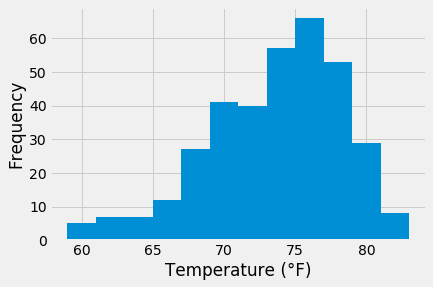

In [14]:
# Choose the station with the highest number of temperature observations.
results = session.query(measurementClass.date, measurementClass.tobs).\
    filter(measurementClass.date >= queryDate).\
    filter(measurementClass.station == "USC00519281").\
    order_by(measurementClass.date)
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_tobs_df = pd.DataFrame(results, columns=['Date', 'Temperature'])
plt.hist(most_tobs_df.Temperature, bins = 12)
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.show()